## Skorch LSTM

- https://discuss.pytorch.org/t/problem-with-skorch-and-rnn-with-lstm-cells/80674/1
- https://github.com/skorch-dev/skorch/issues/632
- https://github.com/skorch-dev/skorch/issues/892
- https://github.com/skorch-dev/skorch/blob/master/examples/rnn_classifer/RNN_sentiment_classification.ipynb

<div style="text-align: right"> <b>Author : Kwang Myung Yu</b></div>
<div style="text-align: right"> Initial upload: 2023. 7. 13</div>
<div style="text-align: right"> Last update: 2023. 7.13</div>

In [1]:
import os
import sys
import time
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from scipy import stats
import warnings; warnings.filterwarnings('ignore')
#plt.style.use('ggplot')
plt.style.use('seaborn-whitegrid')
%matplotlib inline

In [2]:
from sklearn.datasets import make_regression
from skorch import NeuralNetRegressor
import unittest

import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.optim as optim

from sklearn.preprocessing import StandardScaler, MinMaxScaler


In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

### 데이터셋 만들기

In [4]:
url="https://raw.githubusercontent.com/sguys99/datasets/master/BTC-USD.csv"
df = pd.read_csv(url, index_col = "Date", parse_dates = True)
df.drop(columns=['Adj Close'], inplace=True)
print(df.shape)

(3114, 5)


In [5]:
X, y = df.drop('Close', axis = 1), df.Close.values
X.shape, y.shape

((3114, 4), (3114,))

In [6]:
def generate_sequences(
    df: pd.DataFrame,
    train_window: int,
    forecast_window: int,
    target_columns,
    drop_targets = False,
    ):
    '''
    df: Pandas DataFrame of the univariate time-series
    train_window: Integer defining how many steps to look back
    forecst_indow: Integer defining how many steps to predict
    target_colums
    drop_targets: drop target for training model 

    returns: dictionary of sequences and targets for all sequences
    '''
    if drop_targets:
            feature_df = df.drop(target_columns, axis=1)
    else:
        feature_df = df.copy()
    
    data = dict()
    L = len(df)
    for i in range(L-train_window):
        # train_window 사이즈 만큼 피처 시퀀스로 설정 
        sequence = feature_df[i:i+train_window].values
        # 현시점 이후부터 forecast_window 사이즈 만큼 타겟(예측) 범위로 지정
        target = df[i+train_window: i+train_window+forecast_window][target_columns].values
        data[i] = {'sequence': sequence, 'target': target}
        
    return data

In [7]:
class SequenceDataset(Dataset):

  def __init__(self, 
               data: pd.DataFrame
               ):
    self.data = data

  def __getitem__(self, idx):
    sample = self.data[idx]
    return torch.Tensor(sample['sequence']), torch.Tensor(sample['target'])
  
  def __len__(self):
    return len(self.data)

In [8]:
feature_scalers = {}
target_scalers = {}
X = df.drop("Close", axis = 1)
y = df[["Close"]]

for feat in X.columns:
    feature_scalers[feat] = StandardScaler().fit(X[feat].values.reshape(-1, 1))
    
target_scalers["Close"] = MinMaxScaler().fit(y["Close"].values.reshape(-1, 1))

In [9]:
X_norm = X.copy()
y_norm = y.copy()

for i, key in enumerate(feature_scalers.keys()):
  feature_norm = feature_scalers[key].transform(X_norm.iloc[:, i].values.reshape(-1, 1))
  X_norm.iloc[:, i] = feature_norm
  
target_norm = target_scalers["Close"].transform(y_norm.loc[:, "Close"].values.reshape(-1, 1))
y_norm.loc[:,"Close"] = target_norm

In [10]:
df_norm = pd.concat([X_norm, y_norm], axis = 1)

데이터셋 만들기

In [11]:
BATCH_SIZE = 16
train_window = 10
forecast_window = 1

split = 0.8

In [12]:
sequences = generate_sequences(
    df = df_norm,
    train_window=train_window,
    forecast_window=forecast_window,
    target_columns="Close"
)

In [13]:
dataset = SequenceDataset(sequences)

In [14]:
train_len = int(len(dataset)*split)
lens = [train_len, len(dataset)-train_len]
train_ds, test_ds = random_split(dataset, lens)

trainloader = DataLoader(
    train_ds, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    drop_last=True
    )

testloader = DataLoader(
    test_ds, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    drop_last=True
    )

In [15]:
x, y = next(iter(trainloader))
x.shape, y.shape

(torch.Size([16, 10, 5]), torch.Size([16, 1]))

In [16]:
class LSTMForecaster(nn.Module):
    
    def __init__(self,
                 input_size,
                 hidden_size,
                 n_outputs,
                 sequence_len, # length of lookback
                 n_lstm_layers = 1,
                 n_dnn_layers = 100,
                 device = 'cpu',
                 use_cuda = False,
                 dropout = 0.2
                 ):
        '''
        input_size: 입력 피처 수 (1이면 단변량 예측)
        hidden_size: LSTM hidden state size
        n_outputs: 출력(예측) 크기
        n_dnn_layers: LSTM 후단의 DNN layer size
        sequence_len: look back size
        dropout: 0 ~ 1
        '''
        super().__init__()
        
        self.input_size = input_size
        self.sequence_len = sequence_len
        self.n_lstm_layers = n_lstm_layers
        self.n_hidden = hidden_size
        self.n_outputs = n_outputs
        self.device = device
        self.use_cuda = use_cuda
        
        self.lstm = nn.LSTM(
            input_size = self.input_size,
            hidden_size = self.n_hidden,
            num_layers = self.n_lstm_layers,
            batch_first = True
        )
        self.fc1 = nn.Linear(
            in_features=self.n_hidden * self.sequence_len,
            out_features= self.n_hidden
            )
        self.dropout = nn.Dropout(p = dropout)
        
        # Create fully connected layers (n_hidden x n_deep_layers)
        dnn_layers = []
        for i in range(n_dnn_layers):
            # Last layer (n_hidden x n_outputs)
            if i == n_dnn_layers - 1:
                dnn_layers.append(nn.ReLU())
                dnn_layers.append(nn.Linear(self.n_hidden, self.n_outputs))
            # All other layers (n_hidden x n_hidden) with dropout option
            else:
                dnn_layers.append(nn.ReLU())
                dnn_layers.append(nn.Linear(self.n_hidden, self.n_hidden))
                if dropout:
                    dnn_layers.append(nn.Dropout(p=dropout))
        # compile DNN layers
        self.dnn = nn.Sequential(*dnn_layers)
        
    def forward(self, x):
        # Initialize hidden state
        hidden_state = torch.zeros(self.n_lstm_layers, x.shape[0], self.n_hidden)
        cell_state = torch.zeros(self.n_lstm_layers, x.shape[0], self.n_hidden)

        # move hidden state to device
        if self.use_cuda:
            hidden_state = hidden_state.to(self.device)
            cell_state = cell_state.to(self.device)
        
        self.lstm_hidden = (hidden_state, cell_state)

        # Forward Pass
        x, h = self.lstm(x, self.lstm_hidden) # LSTM
        x = self.dropout(x.contiguous().view(x.shape[0], -1)) # Flatten lstm out 
        x = self.fc1(x) # DNN1
        return self.dnn(x) # DNN2

모델 만들기

In [17]:
lr = 4e-4
n_epochs = 20
device = "cpu"

input_size = 5
hidden_size = 50
n_dnn_layers = 5

criterion = nn.MSELoss().to(device)
optimizer = torch.optim.AdamW

In [18]:
lstm_forecaster = NeuralNetRegressor(
    module = LSTMForecaster,
    module__input_size = input_size,
    module__hidden_size = hidden_size,
    module__n_outputs = forecast_window,
    module__sequence_len = train_window,
    module__n_lstm_layers = 1,
    module__n_dnn_layers = n_dnn_layers,
    max_epochs = 50,
    lr = 4e-4,
    iterator_train = DataLoader,
    #iterator_val = DataLoader,
    criterion = criterion,
    optimizer = optimizer
)

In [19]:
train_ds

In [21]:
y_train = np.array([y for X, y in iter(train_ds)])

In [22]:
lstm_forecaster.fit(train_ds, y = y_train)

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.0613        0.0583  0.1328


      2        0.0417        0.0183  0.1254
      3        0.0146        0.0075  0.1375
      4        0.0092        0.0033  0.1174
      5        0.0072        0.0029  0.1126
      6        0.0060        0.0022  0.1112
      7        0.0059        0.0021  0.1108
      8        0.0053        0.0028  0.1115
      9        0.0052        0.0027  0.1115
     10        0.0052        0.0035  0.1113
     11        0.0043        0.0028  0.1102
     12        0.0042        0.0021  0.1118
     13        0.0041        0.0018  0.1103
     14        0.0041        0.0024  0.1106
     15        0.0036        0.0023  0.1122
     16        0.0037        0.0023  0.1104
     17        0.0038        0.0033  0.1109
     18        0.0039        0.0038  0.1116
     19        0.0036        0.0015  0.1110
     20        0.0039        0.0016  0.1106
     21        0.0034        0.0027  0.1101
     22        0.0035        0.0024  0.1112
     23        0.0032        0.0025  0.1111
     24        0.0032        0.0

<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=LSTMForecaster(
    (lstm): LSTM(5, 50, batch_first=True)
    (fc1): Linear(in_features=500, out_features=50, bias=True)
    (dropout): Dropout(p=0.2, inplace=False)
    (dnn): Sequential(
      (0): ReLU()
      (1): Linear(in_features=50, out_features=50, bias=True)
      (2): Dropout(p=0.2, inplace=False)
      (3): ReLU()
      (4): Linear(in_features=50, out_features=50, bias=True)
      (5): Dropout(p=0.2, inplace=False)
      (6): ReLU()
      (7): Linear(in_features=50, out_features=50, bias=True)
      (8): Dropout(p=0.2, inplace=False)
      (9): ReLU()
      (10): Linear(in_features=50, out_features=50, bias=True)
      (11): Dropout(p=0.2, inplace=False)
      (12): ReLU()
      (13): Linear(in_features=50, out_features=1, bias=True)
    )
  ),
)

In [23]:
lstm_forecaster.history

[{'batches': [{'train_loss': 0.08267849683761597, 'train_batch_size': 128},
   {'train_loss': 0.07123533636331558, 'train_batch_size': 128},
   {'train_loss': 0.06781318783760071, 'train_batch_size': 128},
   {'train_loss': 0.06109379231929779, 'train_batch_size': 128},
   {'train_loss': 0.04429559409618378, 'train_batch_size': 128},
   {'train_loss': 0.060801561921834946, 'train_batch_size': 128},
   {'train_loss': 0.0576665922999382, 'train_batch_size': 128},
   {'train_loss': 0.076248399913311, 'train_batch_size': 128},
   {'train_loss': 0.05350117385387421, 'train_batch_size': 128},
   {'train_loss': 0.07557358592748642, 'train_batch_size': 128},
   {'train_loss': 0.046127840876579285, 'train_batch_size': 128},
   {'train_loss': 0.05776519328355789, 'train_batch_size': 128},
   {'train_loss': 0.04481334239244461, 'train_batch_size': 128},
   {'train_loss': 0.06775729358196259, 'train_batch_size': 128},
   {'train_loss': 0.05005301907658577, 'train_batch_size': 128},
   {'train_loss

In [24]:
def plot_losses(train_loss, val_loss):
  fig, ax = plt.subplots(figsize = (12, 5))
  ax.plot(train_loss, label='train loss')
  ax.plot(val_loss, label='val loss')
  plt.legend()
  plt.show()

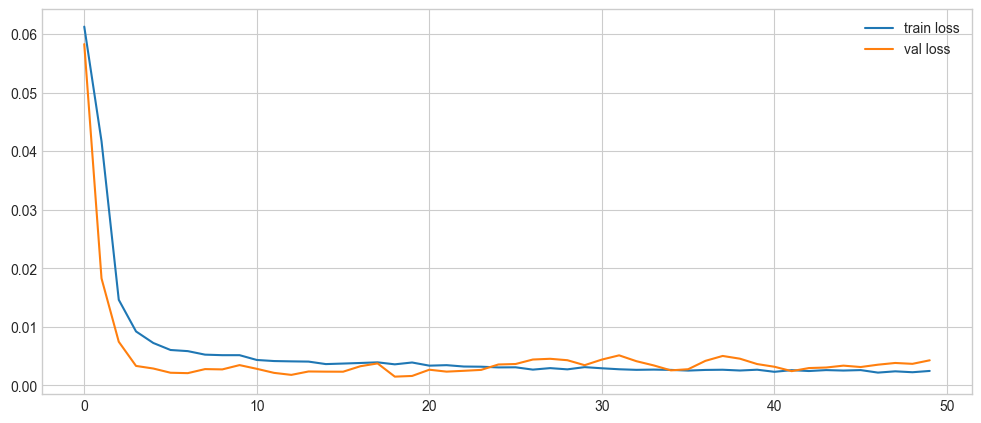

In [25]:
train_loss = lstm_forecaster.history[:, "train_loss"]
val_loss = lstm_forecaster.history[:, "valid_loss"]

plot_losses(train_loss, val_loss)